In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import ast
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
# # 📂 Step 3: Load your CSV file (upload manually or mount Drive)

# df = pd.read_csv("proper_df.csv")

# # # 🧹 Step 4: Combine introduction and conclusion
# # df["combined_text"] = df["introduction_cleaned"] + " " + df["conclusion_cleaned"]

# # 🔧 Step 5: Preprocessing
# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

# def preprocess(text):
#     text = text.lower()
#     tokens = word_tokenize(text)
#     tokens = [t for t in tokens if t.isalpha()]  # remove punctuation/numbers
#     tokens = [t for t in tokens if t not in stop_words]
#     lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
#     return " ".join(lemmatized)

# df["clean_text"] = df["combined_text"].apply(preprocess)

# # 🎯 Step 6: Labels — convert stringified lists to actual lists
# df["labels"] = df["model_family_vector"].apply(ast.literal_eval)
# Install required libraries
# %pip install sentence-transformers scikit-learn

import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

# Step 1: Load your dataset
df = pd.read_csv("proper_df.csv")

# Step 2: Convert label strings to Python lists
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

# Step 3: Combine abstract and section (raw text is best for BERT)
df["combined_text"] = df["abstract_section"].fillna('') + " " + df["section"].fillna('')

# Step 4: Load SentenceTransformer model
model = SentenceTransformer('all-mpnet-base-v2')  # You can switch back to 'all-MiniLM-L6-v2' for faster embeddings

# Step 5: Generate BERT embeddings
bert_embeddings = model.encode(df["combined_text"].tolist(), show_progress_bar=True)

# Step 6: Train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_embeddings, df["labels"].tolist(), test_size=0.2, random_state=42
)

# Step 7: Save for future use
np.save("bert_embeddings.npy", bert_embeddings)
np.save("y_labels.npy", df["labels"].tolist())

print("✅ BERT embeddings shape:", bert_embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

✅ BERT embeddings shape: (688, 768)


In [ ]:
%pip install transformers torch
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_mean_pool_embeddings(text_list, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
            input_ids = encoded_input['input_ids'].to(device)
            attention_mask = encoded_input['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_size)

            # Mean pooling with attention mask
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
            sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask

            embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(embeddings)

In [ ]:
# print("TF-IDF shape:", X_test.shape)
# # Get feature names
# feature_names = tfidf.get_feature_names_out()

# # Get top features for a few example documents
# for i in range(3):  # First 3 rows
#     row = X[i].toarray()[0]
#     top_indices = row.argsort()[-10:][::-1]  # Top 10 TF-IDF values
#     top_words = [feature_names[j] for j in top_indices]
#     print(f"Doc {i+1} top words:", top_words)
# Load BERT model (MiniLM is fast and solid)
from transformers import AutoTokenizer, AutoModel

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the preprocessed text (or use "combined_text" if you want to compare raw vs. clean)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased').to(device)
model = SentenceTransformer('all-mpnet-base-v2')
bert_embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True)
# bert_embeddings = get_mean_pool_embeddings(df["clean_text"].tolist())

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_embeddings, df["labels"], test_size=0.2, random_state=42
)
print("BERT embeddings shape:", bert_embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

BERT embeddings shape: (725, 768)


In [ ]:
import numpy as np

# Save your BERT embeddings and labels (if needed)
np.save("/content/bert_embeddings.npy", bert_embeddings)
np.save("y_labels_new.npy", df["labels"].tolist())

### **Label Frequencies**

y_train_arr shape: (580,)


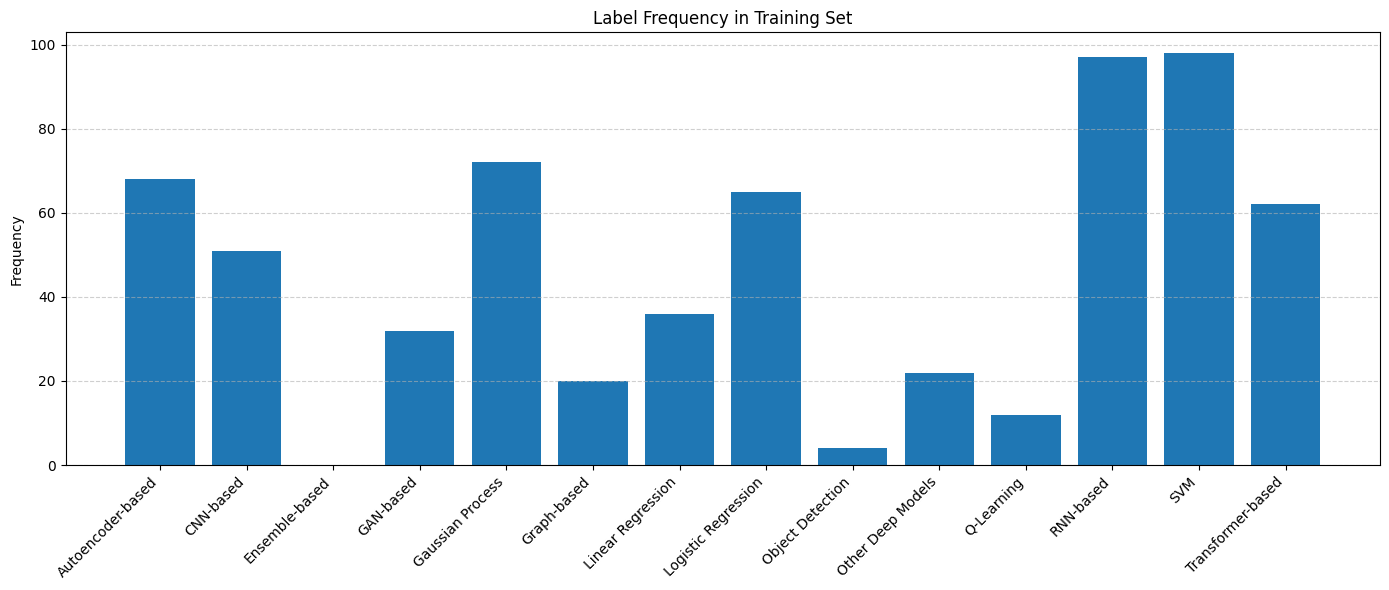

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_train_arr = np.array(y_train_bert)
y_test_arr = np.array(y_test_bert)

print("y_train_arr shape:", y_train_arr.shape)
y_train_arr = np.vstack(y_train_arr)

# Your labels
label_names = ['Autoencoder-based', 'CNN-based', 'Ensemble-based', 'GAN-based',
               'Gaussian Process', 'Graph-based', 'Linear Regression',
               'Logistic Regression', 'Object Detection', 'Other Deep Models',
               'Q-Learning', 'RNN-based', 'SVM', 'Transformer-based']


label_frequencies = y_train_arr.sum(axis=0)

plt.figure(figsize=(14, 6))
plt.bar(label_names, label_frequencies)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Label Frequency in Training Set")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



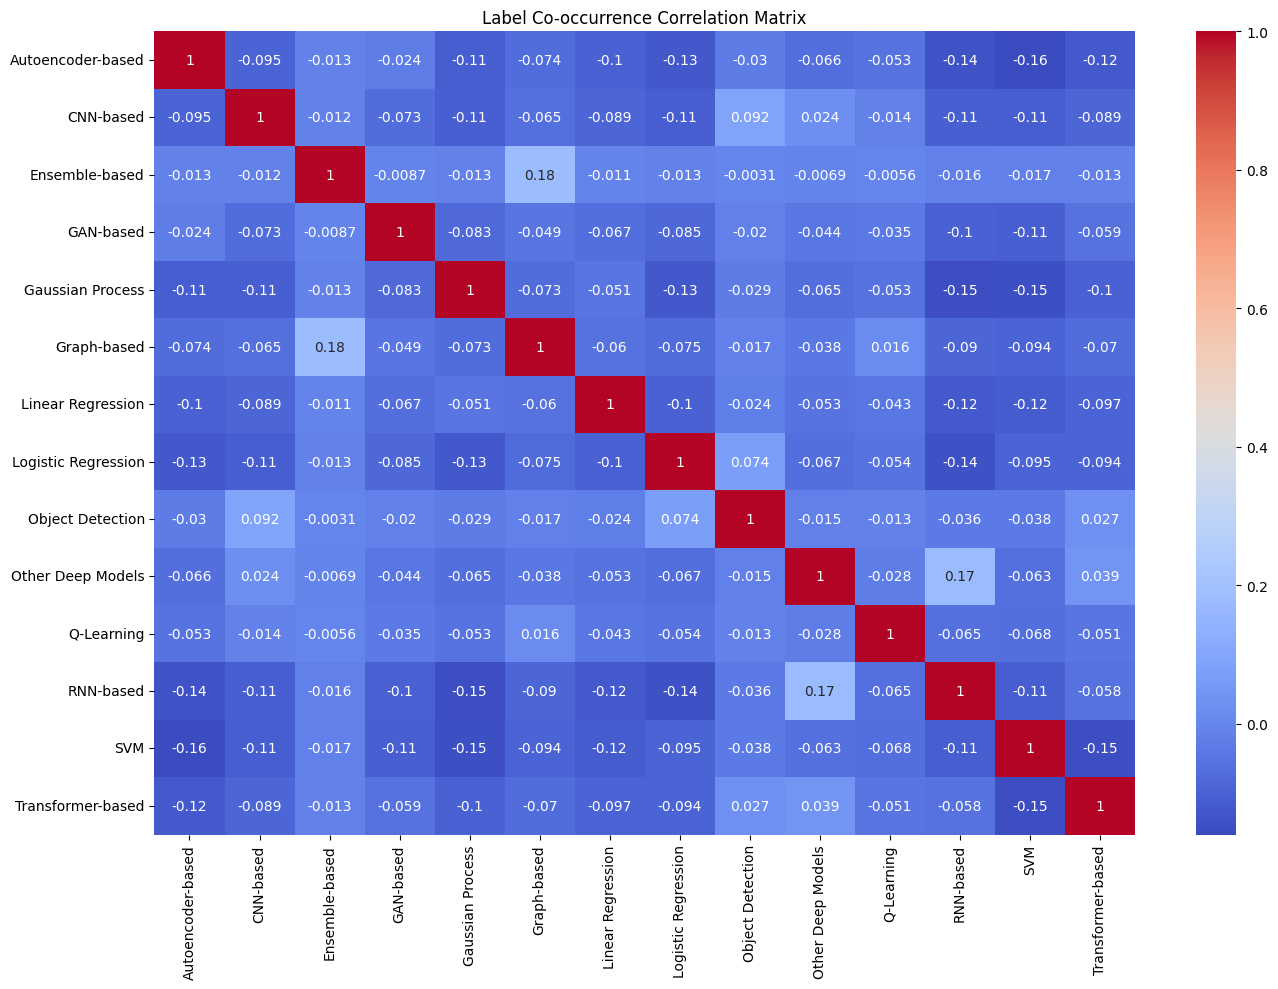

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Load the uploaded file
df = pd.read_csv("proper_df.csv")

# Convert stringified label vectors to actual Python lists
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

# Convert to a 2D NumPy array (label matrix)
label_matrix = np.vstack(df["labels"].values)  # shape: (num_samples, num_labels)

label_names = ['Autoencoder-based', 'CNN-based', 'Ensemble-based', 'GAN-based',
               'Gaussian Process', 'Graph-based', 'Linear Regression',
               'Logistic Regression', 'Object Detection', 'Other Deep Models',
               'Q-Learning', 'RNN-based', 'SVM', 'Transformer-based']
assert label_matrix.shape[1] == len(label_names)

# Turn the label matrix into a DataFrame
label_df = pd.DataFrame(label_matrix, columns=label_names)

# Compute correlation (co-occurrence tendencies)
corr = label_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, xticklabels=True, yticklabels=True)
plt.title("Label Co-occurrence Correlation Matrix")
plt.tight_layout()
plt.show()


## **CLUSTERING**

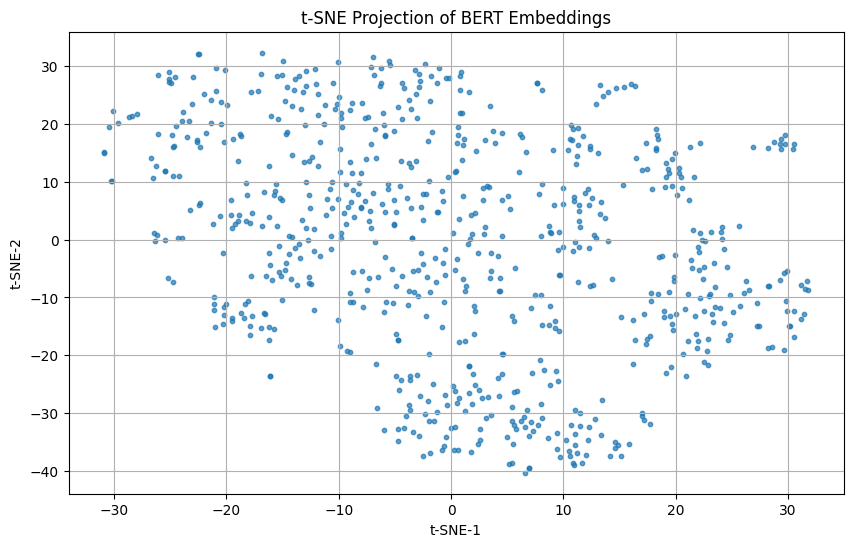

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the BERT embeddings
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embedding_2d_tsne = tsne.fit_transform(bert_embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_tsne[:, 0], embedding_2d_tsne[:, 1], s=10, alpha=0.7)
plt.title("t-SNE Projection of BERT Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()

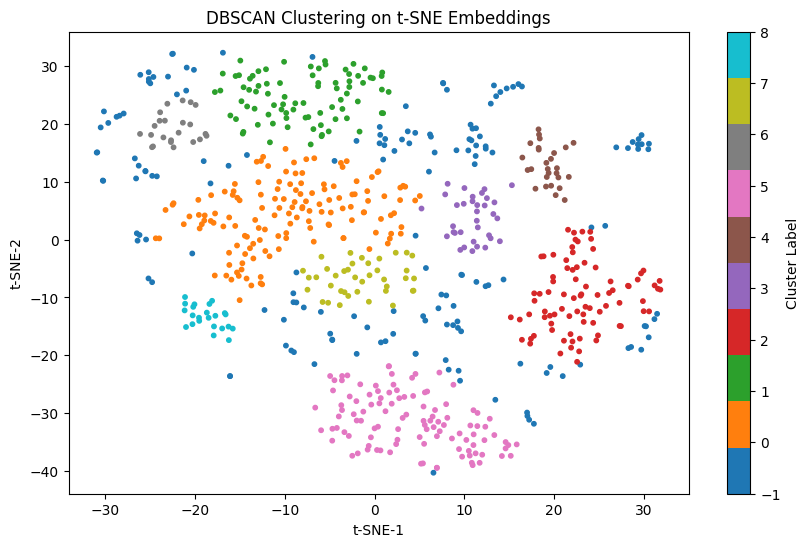

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Run DBSCAN on the 2D t-SNE projection
dbscan = DBSCAN(eps=4, min_samples=15)
cluster_labels = dbscan.fit_predict(embedding_2d_tsne)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_tsne[:, 0], embedding_2d_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("DBSCAN Clustering on t-SNE Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.colorbar(label="Cluster Label")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-reduced shape: (725, 300)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


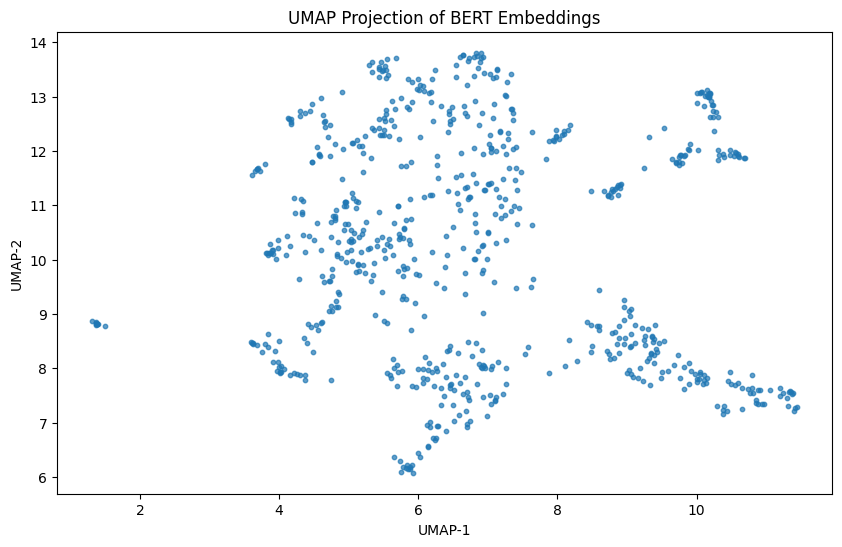

In [ ]:
%pip install umap-learn
import umap
import numpy as np

# Reduce to e.g., 50 or 100 dimensions
umap_reducer = umap.UMAP(n_components=300, random_state=42)
bert_embeddings_reduced = umap_reducer.fit_transform(bert_embeddings)

print("UMAP-reduced shape:", bert_embeddings_reduced.shape)

import matplotlib.pyplot as plt

umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(bert_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)
plt.title("UMAP Projection of BERT Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


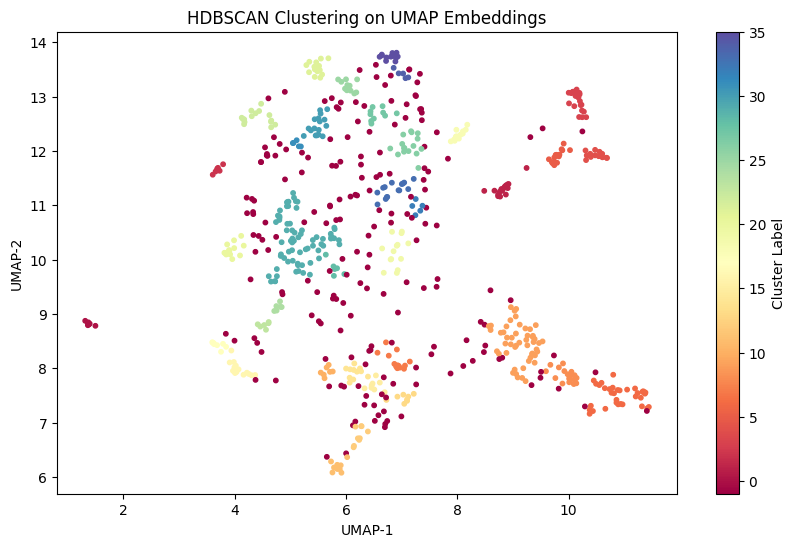

In [ ]:
%pip install hdbscan
import hdbscan
import matplotlib.pyplot as plt

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels = clusterer.fit_predict(embedding_2d)

# Plot with color-coded clusters
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=10)
plt.title("HDBSCAN Clustering on UMAP Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Cluster Label')
plt.show()


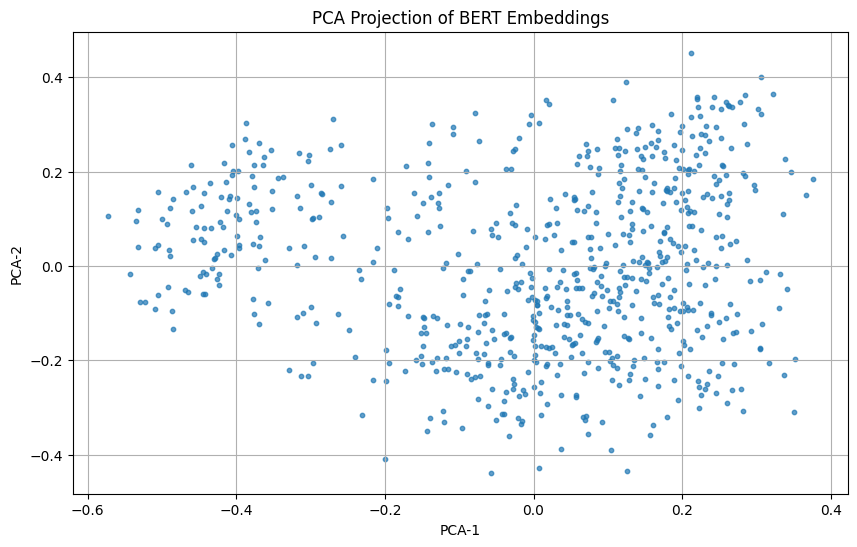

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
embedding_2d_pca = pca.fit_transform(bert_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_pca[:, 0], embedding_2d_pca[:, 1], s=10, alpha=0.7)
plt.title("PCA Projection of BERT Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


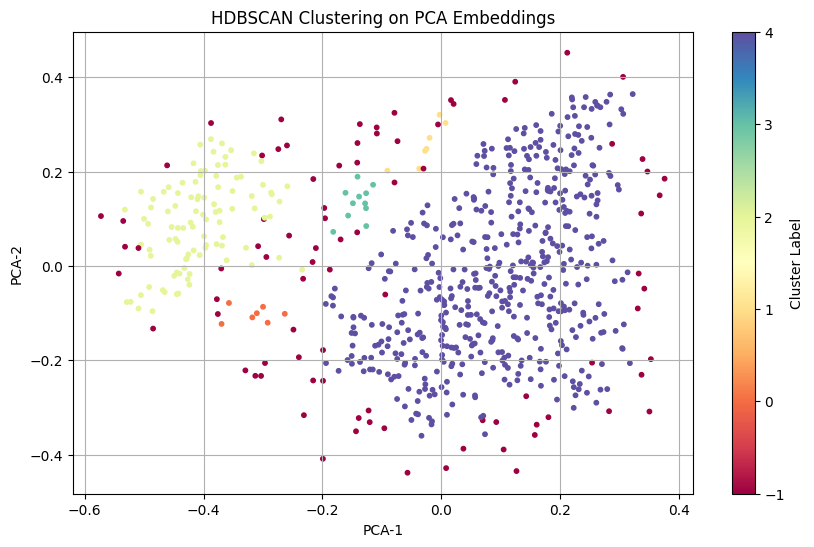

In [ ]:
import hdbscan

clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels_pca_hdbscan = clusterer_pca.fit_predict(embedding_2d_pca)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_pca[:, 0], embedding_2d_pca[:, 1], c=cluster_labels_pca_hdbscan, cmap='Spectral', s=10)
plt.title("HDBSCAN Clustering on PCA Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()


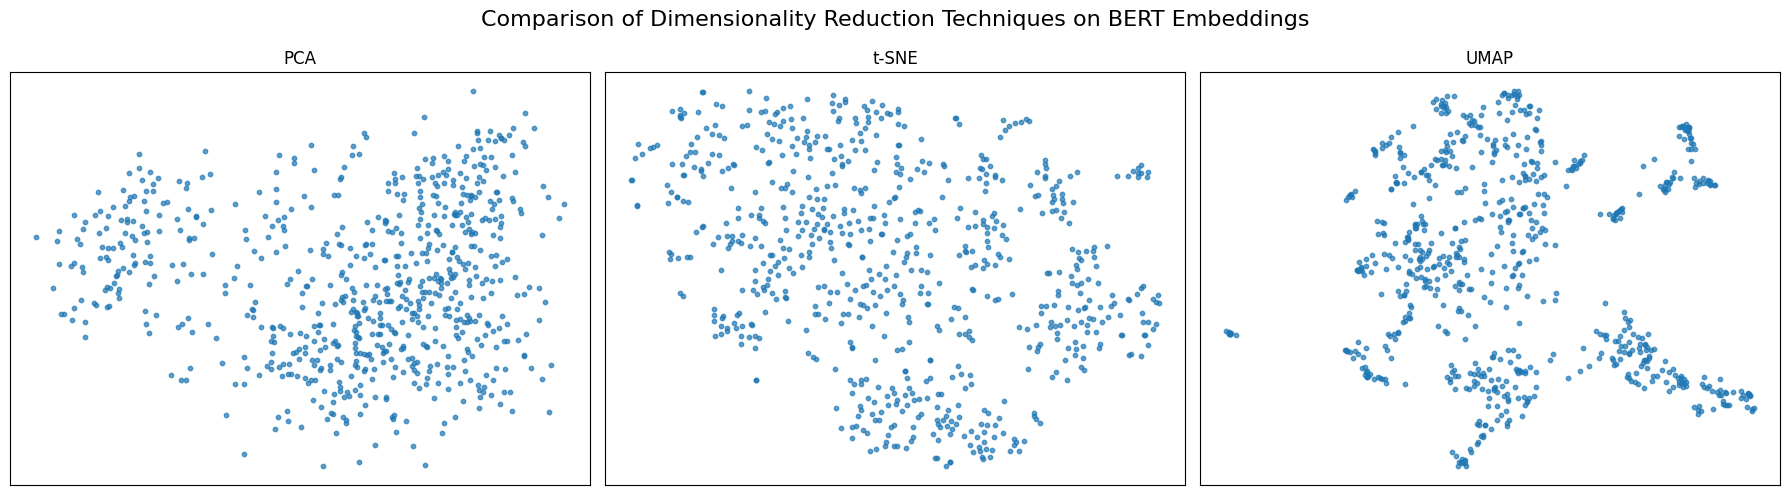

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(embedding_2d_pca[:, 0], embedding_2d_pca[:, 1], s=10, alpha=0.7)
axes[0].set_title("PCA")

axes[1].scatter(embedding_2d_tsne[:, 0], embedding_2d_tsne[:, 1], s=10, alpha=0.7)
axes[1].set_title("t-SNE")

axes[2].scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)  # UMAP
axes[2].set_title("UMAP")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Comparison of Dimensionality Reduction Techniques on BERT Embeddings", fontsize=16)
plt.tight_layout()
plt.show()


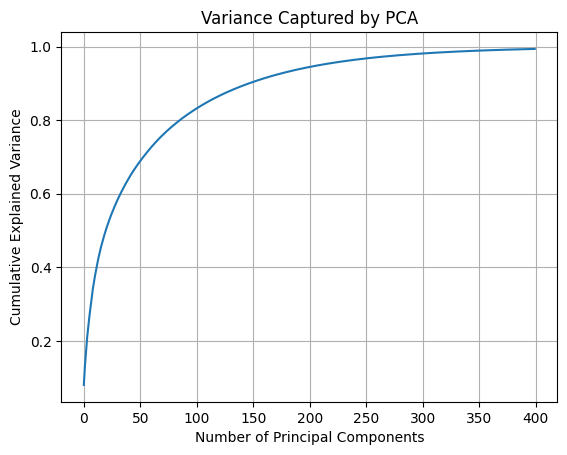

Reduced shape: (725, 400)


In [ ]:

from sklearn.decomposition import PCA

# Reduce to, say, 100 dimensions
pca = PCA(n_components=400)
bert_embeddings_reduced = pca.fit_transform(bert_embeddings)


explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(0, 400), explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Captured by PCA')
plt.grid(True)
plt.show()

print("Reduced shape:", bert_embeddings_reduced.shape)